# Chapter 11 - Notes

## Set Up

### Packages

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats
from scipy.special import expit, logit
from sklearn.preprocessing import StandardScaler

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [3]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"
CHIMPANZEES_FILE = "chimpanzees.csv"
ADMISSIONS_FILE = "ucbadmit.csv"

RANDOM_SEED = 42

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

## 11.1 Binomial regresssion

### 11.1.1 Logistic regression: Prosocial chimpanzees

In [5]:
# load the data
chimps = load_data(CHIMPANZEES_FILE, delimiter=";")

Start with the simplified model. We plot the prior on $p$ for different priors on $\alpha$

In [6]:
def sample_constant_model_prior(chimps, alpha_prior_sigma):
    with pm.Model():
        # prior
        alpha = pm.Normal("alpha", mu=0, sigma=alpha_prior_sigma)

        # model
        p = pm.Deterministic("p", pm.math.invlogit(alpha))

        # likelihood
        pulled_left = pm.Binomial("pulled_left", n=1, p=p, observed=chimps.pulled_left)

        # sample prior predictive
        pp_trace = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

    return pp_trace

Sampling: [alpha, pulled_left]
Sampling: [alpha, pulled_left]
Sampling: [alpha, pulled_left]
Sampling: [alpha, pulled_left]
Sampling: [alpha, pulled_left]


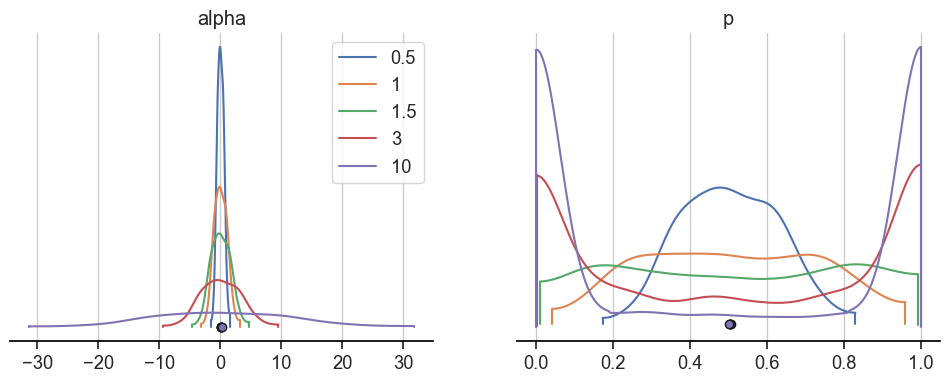

In [7]:
sigmas = [0.5, 1, 1.5, 3, 10]
traces = []
for sigma in sigmas:
    traces.append(sample_constant_model_prior(chimps, sigma))

pm.plot_density(
    traces,
    group="prior",
    data_labels=sigmas,
    var_names=["alpha", "p"],
    hdi_prob=1,
    figsize=(12, 4),
);

Now we create an index variable for treatment.
We also need to create an index for `actor` so that it goes from 0.

In [8]:
chimps["treatment_idx"] = chimps["prosoc_left"] + 2 * chimps["condition"]

treatment_mapper = {
    0: "R/N",
    1: "L/N",
    2: "R/P",
    3: "L/P",
}
chimps["treatment"] = chimps["treatment_idx"].replace(treatment_mapper)

chimps["actor_idx"] = chimps["actor"] - 1

Now do the same but with a fixed $\alpha$ and different priors on $\beta$.

In [9]:
def sample_no_agent_effect_model_prior(chimps, beta_prior_sigma):
    treatments = chimps.sort_values("treatment_idx").treatment.unique()
    coords = {
        "treatment": treatments,
    }
    with pm.Model(coords=coords):
        # data
        treatment_idx = pm.MutableData("treatment", chimps.treatment_idx, dims="obs")

        # priors
        alpha = pm.Normal("alpha", mu=0, sigma=1.5)
        beta = pm.Normal("beta", mu=0, sigma=beta_prior_sigma, dims="treatment")

        # left/right treatment effect
        diff_between_treatments = pm.Deterministic(
            "diff_between_treatments",
            pm.math.abs(
                pm.math.invlogit(alpha + beta[1]) - pm.math.invlogit(alpha + beta[0])
            ),
        )

        # linear model
        p = pm.Deterministic(
            "p", pm.math.invlogit(alpha + beta[treatment_idx]), dims="obs"
        )

        # likelihood
        pulled_left = pm.Binomial(
            "pulled_left", n=1, p=p, observed=chimps.pulled_left, dims="obs"
        )

        # sample the prior predictive
        trace = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

    return trace

Sampling: [alpha, beta, pulled_left]
Sampling: [alpha, beta, pulled_left]
Sampling: [alpha, beta, pulled_left]
Sampling: [alpha, beta, pulled_left]
Sampling: [alpha, beta, pulled_left]


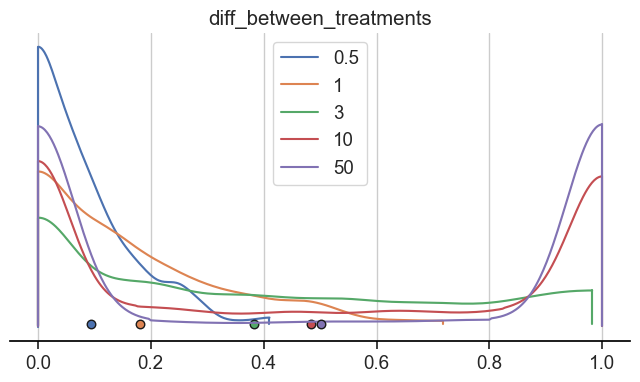

In [10]:
sigmas = [0.5, 1, 3, 10, 50]
traces = []
for sigma in sigmas:
    traces.append(sample_no_agent_effect_model_prior(chimps, sigma))

pm.plot_density(
    traces,
    group="prior",
    data_labels=sigmas,
    var_names=["diff_between_treatments"],
    hdi_prob=1,
    figsize=(8, 4),
);

Finally let's do a sensible model

In [11]:
actors = chimps.sort_values("actor_idx").actor.unique()
treatments = chimps.sort_values("treatment_idx").treatment.unique()
coords = {
    "actor": actors,
    "treatment": treatments,
}
with pm.Model(coords=coords) as m11_3:
    # data
    actor_idx = pm.MutableData("actor", chimps.actor_idx, dims="obs")
    treatment_idx = pm.MutableData("treatment", chimps.treatment_idx, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1.5, dims="actor")
    beta = pm.Normal("beta", mu=0, sigma=0.5, dims="treatment")

    # linear model
    p = pm.Deterministic(
        "p", pm.math.invlogit(alpha[actor_idx] + beta[treatment_idx]), dims="obs"
    )

    # likelihood
    pulled_left = pm.Binomial(
        "pulled_left", n=1, p=p, observed=chimps.pulled_left, dims="obs"
    )

    # sample the prior predictive
    trace_11_3 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Summarise posteriors

In [12]:
az.summary(
    trace_11_3, var_names=["alpha", "beta"], kind="stats", hdi_prob=0.97, round_to=2
)

,mean,sd,hdi_1.5%,hdi_98.5%
alpha[1],-0.44,0.33,-1.21,0.22
alpha[2],3.91,0.76,2.34,5.62
alpha[3],-0.74,0.33,-1.47,-0.04
alpha[4],-0.74,0.33,-1.47,-0.04
alpha[5],-0.45,0.33,-1.24,0.21
alpha[6],0.48,0.34,-0.22,1.26
alpha[7],1.96,0.42,1.07,2.86
beta[R/N],-0.05,0.29,-0.66,0.58
beta[L/N],0.47,0.28,-0.13,1.09
beta[R/P],-0.39,0.28,-0.99,0.22


Now we compare the posteriors for the $\alpha$ values and their inverse logits (i.e. actual probability values)

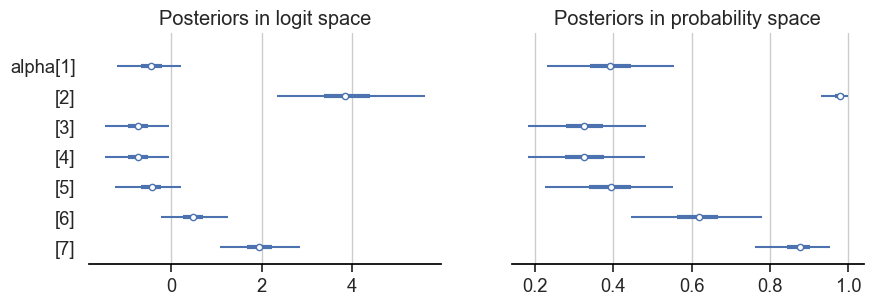

In [13]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 3))

az.plot_forest(
    trace_11_3,
    var_names=["alpha"],
    hdi_prob=0.97,
    combined=True,
    ax=axs[0],
)
axs[0].set_title("Posteriors in logit space")

az.plot_forest(
    expit(trace_11_3.posterior.alpha),
    hdi_prob=0.97,
    combined=True,
    ax=axs[1],
)
axs[1].set_title("Posteriors in probability space");

Now the treatment effect, controlling for individual agent.

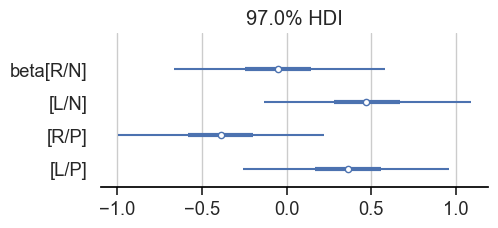

In [14]:
az.plot_forest(
    trace_11_3,
    var_names=["beta"],
    hdi_prob=0.97,
    combined=True,
    figsize=(5, 2),
);

Let's plot the contrasts

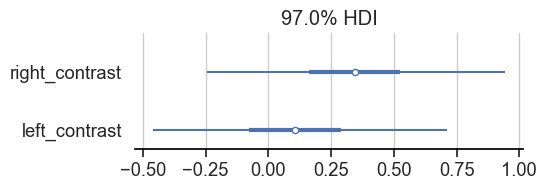

In [15]:
trace_11_3.posterior["right_contrast"] = trace_11_3.posterior.beta.sel(
    treatment="R/N"
) - trace_11_3.posterior.beta.sel(treatment="R/P")
trace_11_3.posterior["left_contrast"] = trace_11_3.posterior.beta.sel(
    treatment="L/N"
) - trace_11_3.posterior.beta.sel(treatment="L/P")

az.plot_forest(
    trace_11_3,
    var_names=["contrast"],
    filter_vars="regex",
    hdi_prob=0.97,
    combined=True,
    figsize=(5, 1.5),
);

### 11.1.3 Aggregated binomial: Chimpanzees again, condensed

In [16]:
# load the data
chimps = load_data(CHIMPANZEES_FILE, delimiter=";")

chimps["treatment_idx"] = chimps["prosoc_left"] + 2 * chimps["condition"]

treatment_mapper = {
    0: "R/N",
    1: "L/N",
    2: "R/P",
    3: "L/P",
}
chimps["treatment"] = chimps["treatment_idx"].replace(treatment_mapper)

chimps["actor_idx"] = chimps["actor"] - 1

Aggregate the data

In [17]:
chimps_agg = (
    chimps.groupby(
        ["treatment", "treatment_idx", "actor", "actor_idx", "prosoc_left", "condition"]
    )
    .pulled_left.sum()
    .reset_index()
    .rename(columns={"pulled_left": "left_pulls"})
)
chimps_agg.head(5)

,treatment,treatment_idx,actor,actor_idx,prosoc_left,condition,left_pulls
0,L/N,1,1,0,1,0,9
1,L/N,1,2,1,1,0,18
2,L/N,1,3,2,1,0,11
3,L/N,1,4,3,1,0,9
4,L/N,1,5,4,1,0,10


Now we can refit the model using all 18 trials at once.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


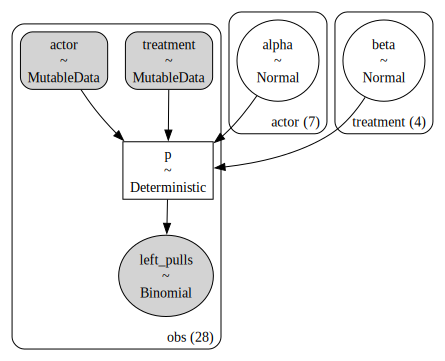

In [18]:
n_trials = 18

actors = chimps_agg.sort_values("actor_idx").actor.unique()
treatments = chimps_agg.sort_values("treatment_idx").treatment.unique()
coords = {
    "actor": actors,
    "treatment": treatments,
}
with pm.Model(coords=coords) as m11_4:
    # data
    actor_idx = pm.MutableData("actor", chimps_agg.actor_idx, dims="obs")
    treatment_idx = pm.MutableData("treatment", chimps_agg.treatment_idx, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1.5, dims="actor")
    beta = pm.Normal("beta", mu=0, sigma=0.5, dims="treatment")

    # linear model
    p = pm.Deterministic(
        "p", pm.math.invlogit(alpha[actor_idx] + beta[treatment_idx]), dims="obs"
    )

    # likelihood
    left_pulls = pm.Binomial(
        "left_pulls", n=n_trials, p=p, observed=chimps_agg.left_pulls, dims="obs"
    )

    # sample the prior predictive
    trace_11_4 = pm.sample(random_seed=RANDOM_SEED)


m11_4.to_graphviz()

Let's compare the posteriors

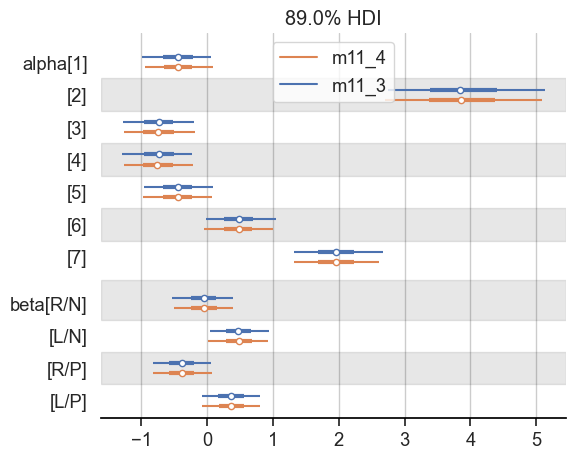

In [19]:
az.plot_forest(
    [trace_11_3, trace_11_4],
    model_names=["m11_3", "m11_4"],
    var_names=["alpha", "beta"],
    filter_vars="regex",
    combined=True,
    hdi_prob=0.89,
    figsize=(6, 5),
);

Observe that the posteriors are identical

### 11.1.4 Aggregated binomial: Graduate school admissions

In [20]:
# load the data
admit = load_data(ADMISSIONS_FILE, delimiter=";")

# cleaning
admit = admit.rename(
    columns={
        "applicant.gender": "gender",
    }
)

admit["admission_rate"] = admit["admit"] / admit["applications"]

# create index variables
admit["gender_idx"], genders = pd.factorize(admit["gender"])
admit["dept_idx"], depts = pd.factorize(admit["dept"])

Start with a simple model with only gender as a feature

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


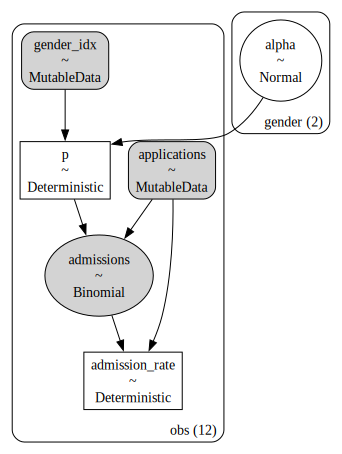

In [21]:
coords = {
    "obs": admit.index,
    "gender": genders,
}
with pm.Model(coords=coords) as m11_7:
    # data
    gender_idx = pm.MutableData("gender_idx", admit.gender_idx, dims="obs")
    applications = pm.MutableData("applications", admit.applications, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1.5, dims="gender")

    # model
    p = pm.Deterministic("p", pm.math.invlogit(alpha[gender_idx]), dims="obs")

    # likelihood
    admissions = pm.Binomial(
        "admissions", n=applications, p=p, observed=admit.admit, dims="obs"
    )
    admission_rate = pm.Deterministic(
        "admission_rate", admissions / applications, dims="obs"
    )

    # inference button
    trace_11_7 = pm.sample(random_seed=RANDOM_SEED)


m11_7.to_graphviz()

In [22]:
az.summary(
    trace_11_7,
    var_names=["alpha"],
    kind="stats",
    hdi_prob=0.89,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[male],-0.219,0.040,-0.285,-0.157
alpha[female],-0.830,0.051,-0.911,-0.748


Let's get the absolute and relative contrasts

In [23]:
with m11_7:
    male_idx = genders.get_loc("male")
    female_idx = genders.get_loc("female")

    abs_contrast = pm.Deterministic("abs_contrast", alpha[male_idx] - alpha[female_idx])
    rel_contrast = pm.Deterministic(
        "rel_contrast",
        pm.math.invlogit(alpha[male_idx]) - pm.math.invlogit(alpha[female_idx]),
    )

    # need to resample
    trace_11_7 = pm.sample(random_seed=RANDOM_SEED)


az.summary(
    trace_11_7,
    var_names=["contrast"],
    filter_vars="regex",
    kind="stats",
    hdi_prob=0.89,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%
abs_contrast,0.611,0.066,0.503,0.711
rel_contrast,0.142,0.015,0.119,0.165


Now let's do a posterior validation check

In [24]:
with m11_7:
    trace_11_7 = pm.sample_posterior_predictive(
        trace_11_7,
        var_names=["admissions", "admission_rate"],
        extend_inferencedata=True,
        random_seed=RANDOM_SEED,
    )

Sampling: [admissions]


In [25]:
def plot_posterior_preditive_checks_by_observation(
    admit, trace, hdi_prob=0.89, ax=None
):
    if not ax:
        fig, ax = plt.subplots(figsize=(7, 3))

    sns.scatterplot(
        x=admit.index,
        y=admit.admission_rate,
        ax=ax,
    )
    for dept in depts:
        dept_data = admit[admit["dept"] == dept]
        ax.plot(
            dept_data.index,
            dept_data.admission_rate,
            color=colors[0],
        )

    sns.scatterplot(
        x=admit.index,
        y=trace.posterior.p.mean(dim=["draw", "chain"]),
        facecolors="none",
        edgecolor="k",
        linewidth=1,
    )

    p_hdi = az.hdi(trace.posterior.p, hdi_prob=0.89)
    ax.plot(
        [admit.index, admit.index],
        [p_hdi.p.sel(hdi="lower"), p_hdi.p.sel(hdi="higher")],
        color="k",
    )

    admission_rate_hdi = az.hdi(
        trace.posterior_predictive.admission_rate, hdi_prob=0.89
    )
    for hdi in admission_rate_hdi.hdi.values:
        sns.scatterplot(
            x=admit.index,
            y=admission_rate_hdi.admission_rate.sel(hdi=hdi),
            marker="_",
            color="k",
            linewidth=1,
        )

    ax.set(
        ylim=[0, 1],
        xlabel="Observation",
        ylabel="Admission rate",
        title="Posterior predictive",
    );

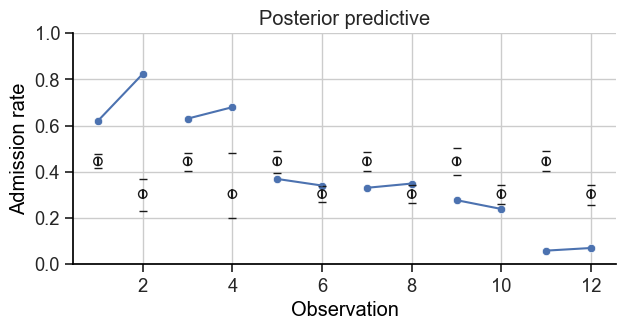

In [26]:
plot_posterior_preditive_checks_by_observation(admit, trace_11_7)

You can see the issue - the model predicts the same admission rate for men and women at each department.

Let's improve the model by adding department as a feature.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, delta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


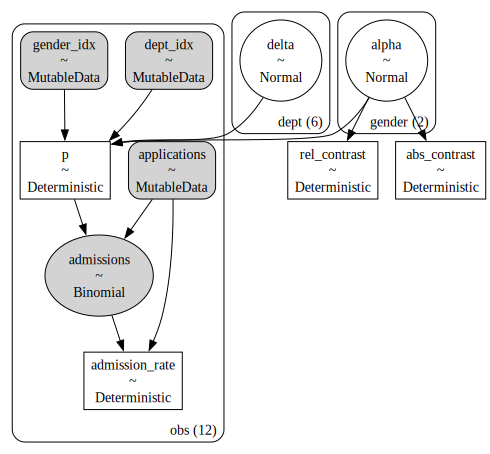

In [27]:
coords = {
    "obs": admit.index,
    "gender": genders,
    "dept": depts,
}
with pm.Model(coords=coords) as m11_8:
    # data
    gender_idx = pm.MutableData("gender_idx", admit.gender_idx, dims="obs")
    dept_idx = pm.MutableData("dept_idx", admit.dept_idx, dims="obs")
    applications = pm.MutableData("applications", admit.applications, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1.5, dims="gender")
    delta = pm.Normal("delta", mu=0, sigma=1.5, dims="dept")

    # model
    p = pm.Deterministic(
        "p", pm.math.invlogit(alpha[gender_idx] + delta[dept_idx]), dims="obs"
    )

    # likelihood
    admissions = pm.Binomial(
        "admissions", n=applications, p=p, observed=admit.admit, dims="obs"
    )
    admission_rate = pm.Deterministic(
        "admission_rate", admissions / applications, dims="obs"
    )

    # contrasts
    male_idx = genders.get_loc("male")
    female_idx = genders.get_loc("female")

    abs_contrast = pm.Deterministic("abs_contrast", alpha[male_idx] - alpha[female_idx])
    rel_contrast = pm.Deterministic(
        "rel_contrast",
        pm.math.invlogit(alpha[male_idx]) - pm.math.invlogit(alpha[female_idx]),
    )

    # inference button - increase draws for convergence
    trace_11_8 = pm.sample(draws=2000, tune=2000, random_seed=RANDOM_SEED)


m11_8.to_graphviz()

Look at the posterior

In [28]:
az.summary(
    trace_11_8,
    var_names=["alpha", "delta"],
    kind="stats",
    hdi_prob=0.89,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[male],-0.498,0.517,-1.390,0.278
alpha[female],-0.401,0.517,-1.295,0.377
delta[A],1.081,0.520,0.221,1.900
delta[B],1.035,0.521,0.137,1.826
delta[C],-0.181,0.520,-0.980,0.693
delta[D],-0.213,0.519,-1.023,0.647
delta[E],-0.657,0.523,-1.483,0.209
delta[F],-2.213,0.528,-3.056,-1.350


Look at the contrasts

In [29]:
az.summary(
    trace_11_8,
    var_names=["contrast"],
    filter_vars="regex",
    kind="stats",
    hdi_prob=0.89,
)

,mean,sd,hdi_5.5%,hdi_94.5%
abs_contrast,-0.097,0.081,-0.228,0.029
rel_contrast,-0.022,0.019,-0.052,0.007


Now let's compare the posterior predictions

Sampling: [admissions]


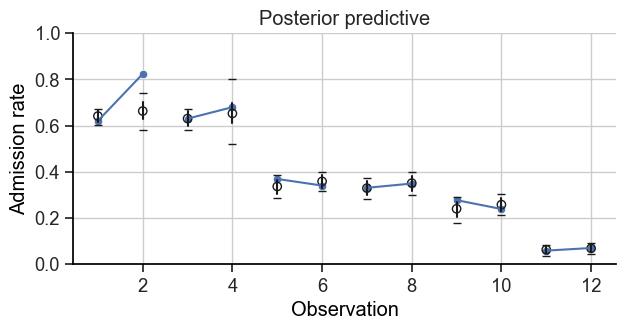

In [30]:
with m11_8:
    trace_11_8 = pm.sample_posterior_predictive(
        trace_11_8,
        var_names=["admissions", "admission_rate"],
        extend_inferencedata=True,
        random_seed=RANDOM_SEED,
    )


plot_posterior_preditive_checks_by_observation(admit, trace_11_8)

This looks much better although department A still doesn't fit very well.

Finally I want to look at the posterior correlations between the parameters.

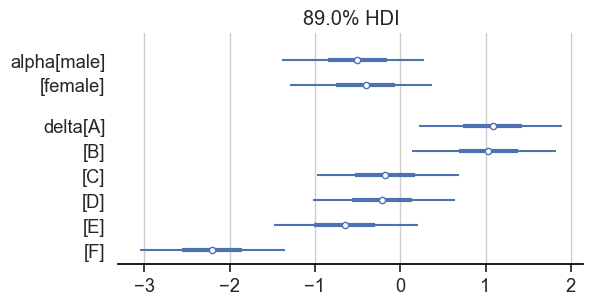

In [31]:
az.plot_forest(
    trace_11_8,
    var_names=["alpha", "delta"],
    combined=True,
    hdi_prob=0.89,
    figsize=(6, 3),
);

Note that the posterior distributions are very wide, but the actual posterior predictions have narrow HDIs.
This is due to posterior correlations.
Let's look at join distributions for pairs of parameters.
We just take the first two departments as an example - the others are similar.

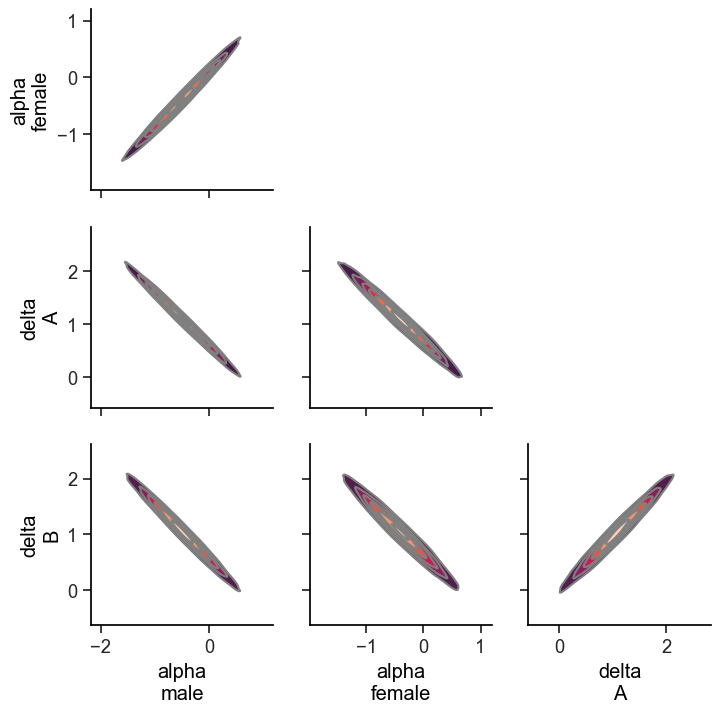

In [32]:
az.plot_pair(
    trace_11_8,
    var_names=["alpha", "delta"],
    coords={"dept": ["A", "B"]},
    kind="kde",
    figsize=(8, 8),
);

There are strong correlations between the posteriors due to redundency in the parameters.
This isn't a problem, but makes the marginal posterior distributions misleading.